In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
import importlib
import math
import torchvision
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

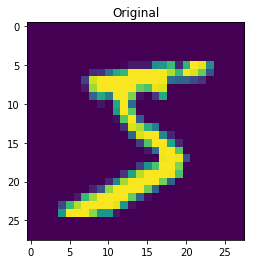

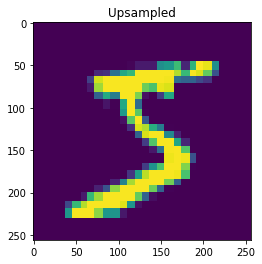

In [53]:
checkpoint = torch.load("data/MNIST/processed/training.pt")
trans = transforms.ToPILImage()
img = trans(checkpoint[0][0])
img_as_img = img.resize((60,60), resample=Image.NEAREST)
img_as_img = img_as_img.resize((100,100), resample=Image.NEAREST)
#img_as_img = img_as_img.resize((150,150), resample=Image.NEAREST)
img_as_img = img_as_img.resize((256,256), resample=Image.NEAREST)
fig = plt.figure()
plt.imshow(img)
plt.title('Original')
fig2 = plt.figure()
plt.title('Upsampled')
plt.imshow(img_as_img)


In [64]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    #torchsummary.summary(model, (3,224,224))
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    #util.visualizeBatch(data_loader)
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for 'nll_loss'
    loss_fn = loss(weights= data_loader.dataset.weight.to(device))
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    trainer = Trainer(model, loss_fn, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)

    trainer.train()

In [65]:
config_file = 'configs/config_groundTruth_upsampled.json'
# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [ ]:
#Train the network
main(config, None)

Total number of training images = 477


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/awoloshu/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:10<00:00, 22767154.60it/s]


pretrainedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0)

Train Epoch: 1 [0/406 (0%)] Loss: 1.132656
Train Epoch: 1 [160/406 (38%)] Loss: 1.016041
Train Epoch: 1 [320/406 (77%)] Loss: 0.863894
    epoch          : 1
    loss           : 0.9681381858312167
    my_metric      : 0.5426136363636364
    f1             : 0.4313497560893697
    precision      : 0.48958612253586165
    recall         : 0.5426136363636364
    balanced_accuracy: 0.4980805142569848
    val_loss       : 0.8173590103785197
    val_my_metric  : 0.44345238095238093
    val_f1         : 0.41263083659635386
    val_precision  : 0.4956705662062805
    val_recall     : 0.44345238095238093
    val_balanced_accuracy: 0.6162753036437247
Saving checkpoint: saved/GroundTruth_cellData_upsampled/0605_190053/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
Train Epoch: 2 [0/406 (0%)] Loss: 0.470332
Train Epoch: 2 [160/406 (38%)] Loss: 0.691588
Train Epoch: 2 [320/406 (77%)] Loss: 0.389074
    epoch          : 2
    loss           : 0.6689536433953506
    my_metric     

    val_balanced_accuracy: 0.7233306146349624
Train Epoch: 13 [0/406 (0%)] Loss: 0.394897
Train Epoch: 13 [160/406 (38%)] Loss: 0.488126
Train Epoch: 13 [320/406 (77%)] Loss: 0.577079
    epoch          : 13
    loss           : 0.5168483234368838
    my_metric      : 0.6691433566433567
    f1             : 0.6372474571887319
    precision      : 0.6491717122540633
    recall         : 0.6691433566433567
    balanced_accuracy: 0.5925585444111463
    val_loss       : 0.3880920161803563
    val_my_metric  : 0.7440476190476191
    val_f1         : 0.6706764135335564
    val_precision  : 0.6761479591836735
    val_recall     : 0.7440476190476191
    val_balanced_accuracy: 0.5211914401388086
Saving checkpoint: saved/GroundTruth_cellData_upsampled/0605_190053/checkpoint-epoch13.pth ...
Saving current best: model_best.pth ...
Train Epoch: 14 [0/406 (0%)] Loss: 0.405287
Train Epoch: 14 [160/406 (38%)] Loss: 0.417275
Train Epoch: 14 [320/406 (77%)] Loss: 0.396329
    epoch          : 14
    los

    f1             : 0.6715551904683188
    precision      : 0.7338212196733417
    recall         : 0.7137237762237763
    balanced_accuracy: 0.6266000346626944
    val_loss       : 0.5400485893090566
    val_my_metric  : 0.6324404761904762
    val_f1         : 0.6029501544207426
    val_precision  : 0.6163451012588944
    val_recall     : 0.6324404761904762
    val_balanced_accuracy: 0.5257575757575758
Train Epoch: 26 [0/406 (0%)] Loss: 0.412084
Train Epoch: 26 [160/406 (38%)] Loss: 0.377354
Train Epoch: 26 [320/406 (77%)] Loss: 0.501853
    epoch          : 26
    loss           : 0.44812328540361845
    my_metric      : 0.7183129370629371
    f1             : 0.6735332565880737
    precision      : 0.7394969831475137
    recall         : 0.7183129370629371
    balanced_accuracy: 0.6226168468137312
    val_loss       : 0.5253670414288839
    val_my_metric  : 0.6696428571428571
    val_f1         : 0.6589533730158731
    val_precision  : 0.6579761904761905
    val_recall     : 0.6696

Train Epoch: 38 [160/406 (38%)] Loss: 0.464069
Train Epoch: 38 [320/406 (77%)] Loss: 0.533779
    epoch          : 38
    loss           : 0.4750948089819688
    my_metric      : 0.6783216783216783
    f1             : 0.616358972263286
    precision      : 0.6424421218356687
    recall         : 0.6783216783216783
    balanced_accuracy: 0.5608655324022336
    val_loss       : 0.5007269183794657
    val_my_metric  : 0.6755952380952381
    val_f1         : 0.6564980158730159
    val_precision  : 0.6510225885225885
    val_recall     : 0.6755952380952381
    val_balanced_accuracy: 0.5025252525252525
Train Epoch: 39 [0/406 (0%)] Loss: 0.571079
Train Epoch: 39 [160/406 (38%)] Loss: 0.459447
Train Epoch: 39 [320/406 (77%)] Loss: 0.491963
    epoch          : 39
    loss           : 0.46882150494135344
    my_metric      : 0.6903409090909091
    f1             : 0.6428380457568803
    precision      : 0.704634120842234
    recall         : 0.6903409090909091
    balanced_accuracy: 0.58976392

    balanced_accuracy: 0.5785924270617054
    val_loss       : 0.45018644134203595
    val_my_metric  : 0.7127976190476191
    val_f1         : 0.6936970921945346
    val_precision  : 0.7019494047619048
    val_recall     : 0.7127976190476191
    val_balanced_accuracy: 0.6493767906811385
Saving checkpoint: saved/GroundTruth_cellData_upsampled/0605_190053/checkpoint-epoch50.pth ...
Train Epoch: 51 [0/406 (0%)] Loss: 0.363496
Train Epoch: 51 [160/406 (38%)] Loss: 0.391280
Train Epoch: 51 [320/406 (77%)] Loss: 0.458830
    epoch          : 51
    loss           : 0.46251388925772446
    my_metric      : 0.6979895104895105
    f1             : 0.652142058747924
    precision      : 0.7062609421665945
    recall         : 0.6979895104895105
    balanced_accuracy: 0.5986285212372169
    val_loss       : 0.4562303423881531
    val_my_metric  : 0.6964285714285715
    val_f1         : 0.6705318004846307
    val_precision  : 0.7150986552028217
    val_recall     : 0.6964285714285715
    val_bala

Train Epoch: 63 [160/406 (38%)] Loss: 0.444626
Train Epoch: 63 [320/406 (77%)] Loss: 0.596631
    epoch          : 63
    loss           : 0.4809420383893527
    my_metric      : 0.6894667832167832
    f1             : 0.6397860873135974
    precision      : 0.7213868672588831
    recall         : 0.6894667832167832
    balanced_accuracy: 0.5923475143891236
    val_loss       : 0.3553965538740158
    val_my_metric  : 0.7440476190476191
    val_f1         : 0.6785332722832722
    val_precision  : 0.6312650866798332
    val_recall     : 0.7440476190476191
    val_balanced_accuracy: 0.5443984357027835
Saving checkpoint: saved/GroundTruth_cellData_upsampled/0605_190053/checkpoint-epoch63.pth ...
Saving current best: model_best.pth ...
Train Epoch: 64 [0/406 (0%)] Loss: 0.329441
Train Epoch: 64 [160/406 (38%)] Loss: 0.542182
Train Epoch: 64 [320/406 (77%)] Loss: 0.368894
    epoch          : 64
    loss           : 0.45555625282801115
    my_metric      : 0.670236013986014
    f1           

    recall         : 0.6931818181818182
    balanced_accuracy: 0.5895237012384469
    val_loss       : 0.502929170926412
    val_my_metric  : 0.6964285714285715
    val_f1         : 0.6266541448033053
    val_precision  : 0.6022803287981859
    val_recall     : 0.6964285714285715
    val_balanced_accuracy: 0.530969111403894
Train Epoch: 76 [0/406 (0%)] Loss: 0.472111
Train Epoch: 76 [160/406 (38%)] Loss: 0.532586
Train Epoch: 76 [320/406 (77%)] Loss: 0.463793
    epoch          : 76
    loss           : 0.45868900189032924
    my_metric      : 0.708479020979021
    f1             : 0.6607332823904003
    precision      : 0.7285123212735088
    recall         : 0.708479020979021
    balanced_accuracy: 0.6062523549106793
    val_loss       : 0.46188899874687195
    val_my_metric  : 0.6964285714285715
    val_f1         : 0.6379535147392289
    val_precision  : 0.6086512418357656
    val_recall     : 0.6964285714285715
    val_balanced_accuracy: 0.5429000146391451
Train Epoch: 77 [0/406 (

Train Epoch: 88 [320/406 (77%)] Loss: 0.422560
    epoch          : 88
    loss           : 0.44325459461945754
    my_metric      : 0.6809440559440559
    f1             : 0.632508062815502
    precision      : 0.6877634685980063
    recall         : 0.6809440559440559
    balanced_accuracy: 0.5777035482278449
    val_loss       : 0.5347424944241842
    val_my_metric  : 0.5491071428571429
    val_f1         : 0.4768521132651567
    val_precision  : 0.4653568158032444
    val_recall     : 0.5491071428571429
    val_balanced_accuracy: 0.44964422550629446
Train Epoch: 89 [0/406 (0%)] Loss: 0.408043
Train Epoch: 89 [160/406 (38%)] Loss: 0.619189
Train Epoch: 89 [320/406 (77%)] Loss: 0.411119
    epoch          : 89
    loss           : 0.4735028285246629
    my_metric      : 0.6754807692307693
    f1             : 0.6224026826530713
    precision      : 0.6605806616008922
    recall         : 0.6754807692307693
    balanced_accuracy: 0.575080216777101
    val_loss       : 0.47313945492108

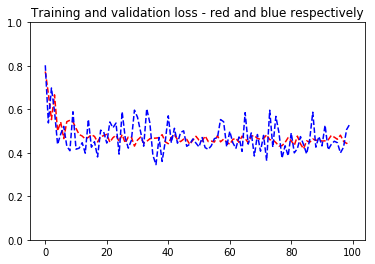

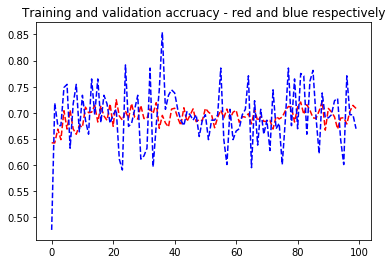

done


In [58]:
saved_dir = 'saved/GroundTruth_cellData_upsampled/0605_190053'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir) #imported from utils

print('done')

In [43]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('class0', 'class1')
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                util.visualizationOutGray(data, output, target, classes, normalized)
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        plt.show()
                      
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    print("My_metric is accuracy")
    

In [44]:
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/11 [00:00<?, ?it/s]

pretrainedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

100%|██████████| 11/11 [00:00<00:00, 11.24it/s]


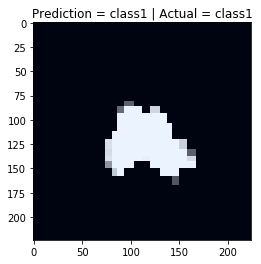

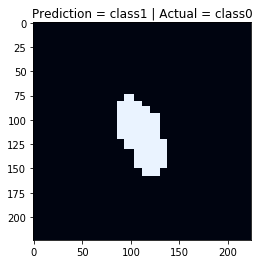

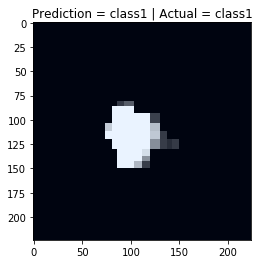

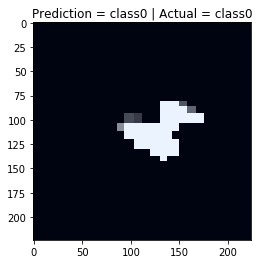

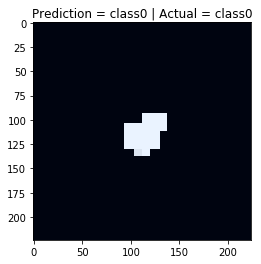

num test images = 83
loss = 0.7688
my_metric = 0.6024
f1 = 0.5773
precision = 0.7053
recall = 0.6024
balanced_accuracy = 0.6226
My_metric is accuracy


In [45]:
#Test
main2(config, resume)